In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

C:\Users\irvin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\irvin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\irvin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
pd.options.mode.chained_assignment = None
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 

In [3]:
project_df = pd.read_csv("./project_data.csv")
project_df

,API,year,month,oil
0,A_30015420120000,2015,FEB,0
1,A_30015420120000,2015,MAR,5329
2,A_30015420120000,2015,APR,2996
3,A_30015420120000,2015,MAY,2369
4,A_30015420120000,2015,JUN,1957
...,...,...,...,...
3019,A_30015424970000,2018,JAN,1976
3020,A_30015424970000,2018,FEB,1650
3021,A_30015424970000,2018,MAR,1964
3022,A_30015424970000,2018,APR,1437


In [4]:
project_df["oil"].max()

55938

In [5]:
well_list = project_df["API"].unique()

In [6]:
month_dict = {
    "JAN": 0,
    "FEB": 1,
    "MAR": 2,
    "APR": 3,
    "MAY": 4,
    "JUN": 5,
    "JUL": 6,
    "AUG": 7,
    "SEP": 8,
    "OCT": 9,
    "NOV": 10,
    "DEC": 11
}

In [7]:
def process_data(df: pd.DataFrame) -> bool:
    if len(df) <= 5:
        return False
    df.loc[:, "month"] = df.loc[:, "month"].apply(lambda x: month_dict[x])
    base_year = df["year"].min()
    df.loc[:, "timestep"] = df.loc[:, "month"] + (df.loc[:, "year"] - base_year) * 12
    df.loc[:, "timestep"] = df.loc[:, "timestep"] - df.loc[:, "timestep"].min()
    return True

In [8]:
def generate_fit_loss(params: np.array, df: pd.DataFrame, loss_func: callable) -> float:
    X = df["timestep"]
    y = df["oil"]
    preds = X.apply(fit_decline_curve, args=(params, ))
    return loss_func(y, preds)

In [9]:
def fit_decline_curve(timestep, params: np.array) -> float:
    """
    params:
        0: q_0
        1: D_0
        2: D_1
        3: b
        4: t_1
        
    timestep: the timestep of the well
    """
    q1 = params[0] * np.exp(params[1] * timestep)
    if timestep > params[-1]:
        return q1 / (1 + params[3] * params[2] * (timestep - params[-1])) ** (1/params[3])
    else:
        return q1    

We've successfully created a Data Processing function, along with a validation function that takes different loss functions to evaluate the loss on. Now let's run the scipy optimizer on each well to see what our wells get.

In [10]:
results_df = pd.DataFrame(columns=["score", "params"], index=well_list)

In [11]:
%%time
for well in well_list:
    well_log = project_df[project_df["API"] == well]
    length_bool = process_data(well_log)
    if not length_bool:
        continue
    bounds = ((0, well_log["oil"].max()), (0, 3), (0, 3), (0, 1), (0, len(well_log)))
    result = differential_evolution(generate_fit_loss, bounds, args=(well_log, mean_squared_error))
    results_df.loc[well] = {"score": result.fun, "params": result.x}

Wall time: 7min 41s


Evaluated Scores

In [14]:
results_df["score"]

A_30015420120000      280642.813699
A_30015420140000         1606.89833
A_30015420220000     2021502.714993
A_30015420300000     1188218.401419
A_30015420320000      479749.446268
                         ...       
A_30015424860000      515228.509147
A_30015424870000      763953.835963
A_30015424890000      650847.364288
A_30015424900000       48010.406652
A_30015424970000    14289345.663965
Name: score, Length: 100, dtype: object

At this point, it'd probably be smarter to unpack the parameters into their own columns, but it's easier to just leave them as they are and I'm trying to go quickly.

C:\Users\irvin\anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\irvin\anaconda3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


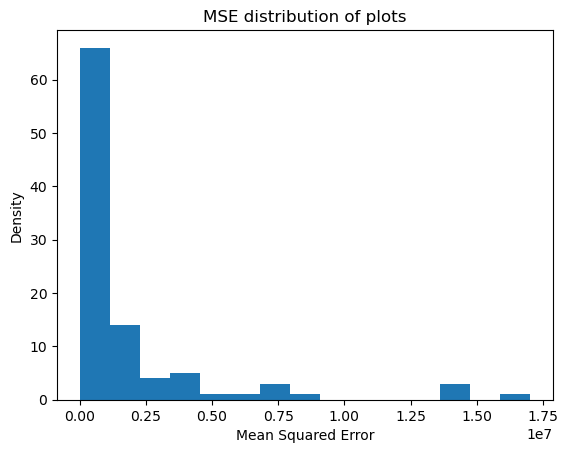

In [12]:
plt.hist(results_df["score"], bins=15)
plt.title("MSE distribution of plots")
plt.xlabel("Mean Squared Error")
plt.ylabel("Density")
plt.show()

In [13]:
for idx, well in enumerate(well_list[:4]):
    well_log = project_df[project_df["API"] == well]
    process_data(well_log)
    fig, ax = plt.subplots()
    ax.scatter(well_log["timestep"], well_log["oil"])
    X = np.arange(0, len(well_log), .01)
    params = results_df.loc[well, "params"]
    vector_func = np.vectorize(fit_decline_curve, excluded=["params"])
    preds = vector_func(timestep=X, params=params)
    ax.plot(X, preds)
    ax.set_title(f"Well {idx}: {well}")
    fig.savefig(f"./{well}.png")

## Loss Discussion

For my loss function, I played around with MAPE, but got truly terrible plots as shown: 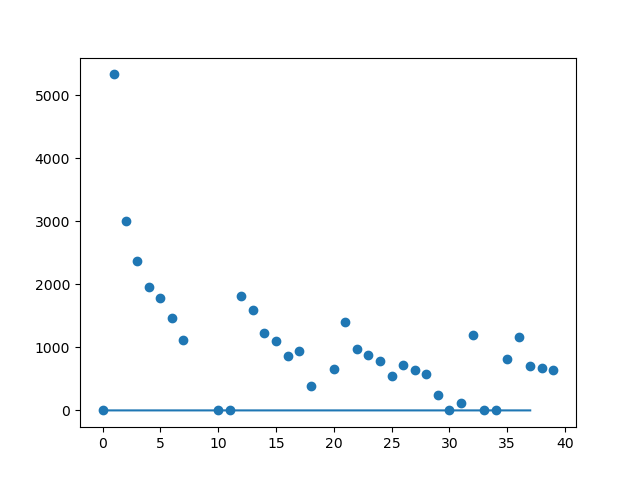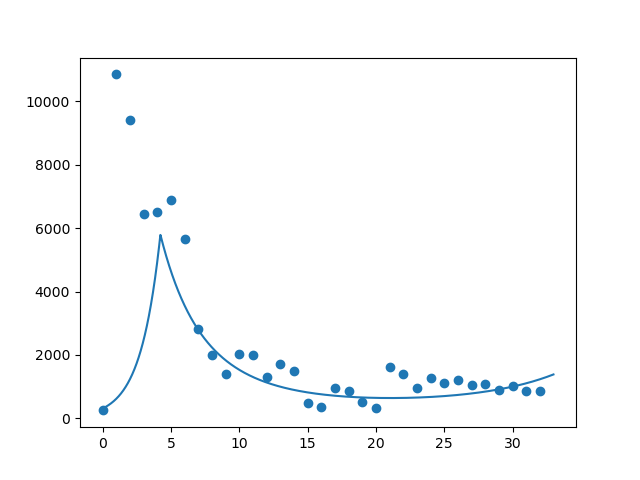

In the end, I decided to use MSE. Something like MAPE or MSlogE would make sense as the functions have an exponential component, but it seems that they're not properly penalizing when trying to fit the larger values, as there can be a large amount of near-0 values towards the end of production.

## Outlier Detection

I struggled mightily with this and ended up unable to find a decent idea for masking outliers due to the piecewise nature of the data and the fact that we need to identify outliers prior to modelling. Obviously we could do the immoral thing and rip out high-MSE points after fitting to try and reduce error, but that would be a leakage of data. 

My alternative idea was to set a moving mask where the point must not be less than 5% of the prior value or more than 200% of the prior value. This would not work in practice though, as shown in Well 3, at times the production is fairly low, then just drops to 0. This makes sense if the well is near-dry and would effectively remove many of our points

## Model Evaluation

I believe that MAPE or MSlogE or even R^2 when log-transforming the oil production outputs would make a lot of sense. Since the functions are working at least partially in log space and otherwise in an effective inverse root space, perhaps MSE would be a good baseline metric to evaluate since we are working with a piece-wise function for the flowrates.